In [2]:
#import packages
import flopy
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mp
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import os
import csv
import seaborn as sns
from pyDOE import *

#additional analysis tools
import flopy.utils.binaryfile as bf
from flopy.utils.sfroutputfile import SfrFile

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
np.set_printoptions(threshold=np.inf)

moddir="C:/WRDAPP/MF2005.1_12/bin/mf2005.exe"
#modws ="C:/Users/davem/Documents/Thesis/modflow/mfoutput"
modws = "D:/mfoutput"
#modws= "D:/mfoutput/transientDrawdown"

#jupyter specific--included to show plots in notebook
%matplotlib inline 

8
RangeIndex(start=0, stop=692, step=1)
Int64Index([  1,   2,   6,   7,   8,   9,  10,  11,  12,  14,
            ...
            675, 676, 677, 678, 679, 682, 684, 688, 689, 690],
           dtype='int64', length=306)


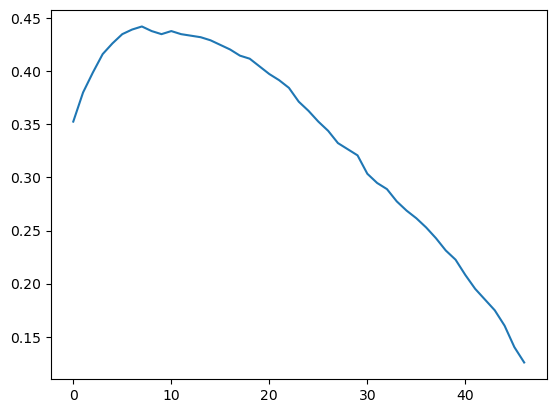

In [2]:
#Getting rid of ensembles with 0 flow at reach 25
ReachQdf = pd.read_pickle('outputs/SS_reachQ.pkl')

#ReachQdf = pd.DataFrame(ReachQ)

numgrz = [len(ReachQdf[i][ReachQdf[i] > 0].index)/len(ReachQdf.index) for i in range(50)] 
print(numgrz.index(max(numgrz)))
plt.plot(numgrz[1:48])
print(ReachQdf.index)

rn_highest = numgrz.index(max(numgrz)) #find reach with greatest number of wet ensembles 
ReachQdf = ReachQdf[ReachQdf[rn_highest] > 0]

print(ReachQdf.index)

In [ ]:
error_list = np.loadtxt("mf_notebooks/ErrorSS_SfrWell1000Test12.txt")
eidx = np.array(error_list)[:,0].astype(int)
# #print(eidx)
temprange = np.arange(1000)
error_free = np.delete(temprange, eidx, axis=0)
print(len(error_free))
# error_list2 = np.loadtxt("outputs/ErrorSS_SfrWell750Test3.txt") #used the error free simulations from test 3 in test 5 so have to bring those in again to remove them to create the error list
# #eidx2 = np.array(error_list2)[:,0].astype(int)
# temprange2 = np.arange(750-len(error_list2))
# #error_free = temprange[eidx]
# error_free = temprange2#np.delete(temprange2, eidx, axis=0)

if eidx.shape[0] == 0:
    error_free = temprange #if no errors
    

testnum = "12"

#error_free = np.loadtxt("mf_notebooks/ModflowSfrWellOutput1000Test"+str(testnum)+".txt")
#print(len(error_free))

#Sey up arrays to store reach data and budget data
ReachAqf = np.ndarray((len(error_free),50))
#ReachAqf = np.ndarray((100,50)) #for testing CMS
depth = np.ndarray((len(error_free),50))
width = np.ndarray((len(error_free),50))
q = np.ndarray((len(error_free),50))


#Should change this to be multi-level index - one day
for j,i in enumerate(error_free.astype('int')):
#for j,i in enumerate(range(100)): #for testing CMS
    modelname = "/ScenarioSfrWell1000Test12_"+str(i) #test 7 has no _ , test 11 does
    sfrout = SfrFile(modws+'\\'+modelname+'.sfr.out')
    Sfrdf = sfrout.get_dataframe() 
   # print(Sfrdf.columns)
    ReachAqf[j] = Sfrdf.Qaquifer
    depth[j] = Sfrdf.depth
    width[j] = Sfrdf.width
    q[j] = Sfrdf.Qout[:]
    plt.plot(Sfrdf.Qout[:])
#plt.yscale('log')    

In [ ]:
ReachAqfdf = pd.DataFrame(ReachAqf, index = error_free).fillna(0)
depthdf = pd.DataFrame(depth,index = error_free)#.fillna(0)
velocity = np.nan_to_num(q/(depth * width) / 86400) #converting to m/s
vel_df = pd.DataFrame(velocity,index = error_free).fillna(0)
width_df = pd.DataFrame(width).fillna(0)
q_df =pd.DataFrame(q, index = error_free).fillna(0) 
#ReachAqfdf = ReachAqfdf.loc[ReachQdf.index]
#display(ReachAqfdf)

fig, axs = plt.subplots(2, 1, sharex=True, sharey=False,figsize=(8, 6))
#fig.suptitle('Variations in Aquifer Discharge and Stream Reach Outflow across Stream Reaches ')
#fig.supylabel('Discharge (cmd) - Log Scale')
fig.supxlabel('Reach Number')
fig.tight_layout(pad = 2)

for i in ReachAqfdf.index:  
#for i in range(100):
    axs[1].plot(ReachAqfdf.loc[i]*-1, alpha = 0.5) 
    axs[0].plot(q_df.loc[i], alpha = 0.5)
    #axs[2].plot(vel_df.loc[i], alpha = 0.5)
   # axs[3].plot(depthdf.loc[i], alpha = 0.5)

axs[1].title.set_text('Aquifer Flux across Reaches for each Ensemble Member')
axs[1].set_ylabel('Flux (cmd)')
#axs[2].set_ylim((0,5))
#axs[3].set_ylim((0,20))
axs[1].axhline(0, color='black', linewidth=.5)

axs[0].title.set_text('Reach Outflow for each Ensemble Member')
axs[0].set_ylabel('Discharge (cmd)')
# axs[2].title.set_text('Velocity across All 50 Reaches for All Simulations')
# axs[2].set_ylabel('Velocity (m/s)')
# axs[3].title.set_text('Depth across All 50 Reaches for All Simulations')
# axs[4].set_ylabel('Depth (m)')


In [ ]:
#Plot out the parameters per ensemble discharge at reach 25

#Uncomment line below if pulling from pkl file
#ReachQdf = pd.read_pickle('outputs/SS_reachQ.pkl')
ReachQdf = pd.read_pickle('outputs/SS_reachQ1000_Test12.pkl')
sampling = np.loadtxt("mf_notebooks/ModflowParams8-1000Test12.txt")
params = pd.DataFrame(sampling, columns=col_names[:-1])
#print(X.index, ReachQdf.index)
params = params.loc[ReachQdf.index]


fig, axs = plt.subplots(4, 2, sharex=False, sharey=False,figsize=(8, 10))
fig.suptitle('Parameter Values with Reach 32 Outflow Discharge for All Simulations')
fig.supylabel('Discharge (cmd) - Log Scale')
fig.supxlabel('Parameter values')
fig.tight_layout(pad = 3.5)
#fig.delaxes(axs[3,1])
# for i in range(len(col_names) - 1):
#     axs.plot(X[col_names[i]],Y,'k.')
i=0
logpars = [1,4]
for row in axs:
    for col in row: 
        col.plot(params[col_names[i]],ReachQdf[32],'.')
        col.title.set_text(col_dict[col_names[i]])
        if i in logpars:
            col.set_xscale('log')
        col.set_yscale('log')
        if i < (len(col_names)-2):
            i+=1
        else:
            break

In [ ]:
## PLotting out Correlations of reach flows
##examine flows for every reach compared to ds most reach (49)

#print(ReachQdf.head())
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle('Plotting sets of reaches to the final reach outflow')
fig.supylabel('Discharge')
fig.supxlabel('Discharge at Downstream Reach')

k=10
for row in axs:
    for col in row:        
        for i in range(k,k+10,10):
            col.plot(ReachQdf[49],ReachQdf[i], '.')
            col.title.set_text('Reaches ' +str(k) +' through ' +str(k+10))
        k+=10

plt.xlim(0,int(ReachQdf[49].max()))
plt.ylim(0,int(ReachQdf[49].max()))
plt.show()

    
ReachQdf.corrwith(ReachQdf[49]).plot()
plt.title('Correlation of All Reaches with Reach 49 Q out ')
plt.ylabel('Pearson\'s r')
plt.xlabel('Reach Number')

306


C:\Users\davem\anaconda3\lib\site-packages\flopy\plot\crosssection.py:1693: MatplotlibDeprecationWarning: Passing the match_original parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  patches = PatchCollection(rectcol, match_original, **kwargs)


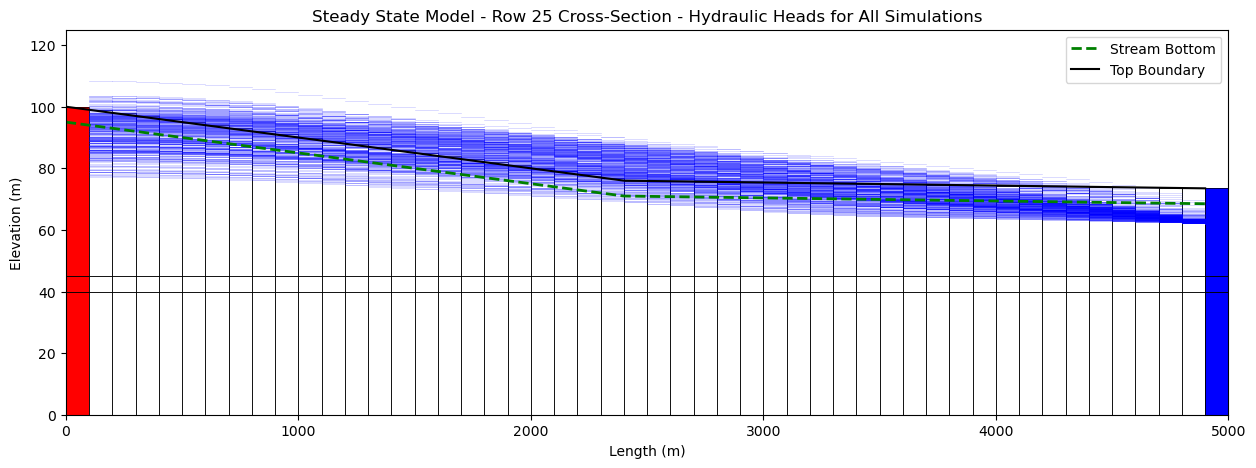

In [11]:
#temprange = np.arange(750)
#eidx = np.array(error_list)[:,0].astype(int)
#error_free = np.delete(temprange, eidx, axis=0)
mn = "D:/mfoutput/ScenarioSfrWell750_0.nam"
#mn = "D:/mfoutput/transientDrawdown/ScenarioSfr750SteadyPumpTest_0.nam"
# error_free = np.loadtxt("ModflowSfrWellOutput750Test3.txt")
# print(error_free[-1])

# outputdf = pd.read_csv('TransOutputStpSteadyPumpTest.csv') 
# outputdf = outputdf[['simnum','Qout','reach','Stp']].reset_index() #only keep the cols we need
# simlist = outputdf['simnum'].unique()
simlist = ReachQdf.index
print(len(simlist))


ztop = np.genfromtxt('base/base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)

reach = ztop[25] - 5
m = flopy.modflow.Modflow.load(mn)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 25}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect.plot_grid(color='green')
# t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')
#headpc = head[0]
#pc = xsect.plot_array(headpc,head=headpc, alpha=0.5)
#patches = xsect.plot_ibound(head=head[0][0])
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('Steady State Model - Row 25 Cross-Section - Hydraulic Heads for All Simulations')
xlabel = ax.set_xlabel('Length (m)')
ylabel = ax.set_ylabel('Elevation (m)')

#cb = plt.colorbar(pc, shrink=0.75)

#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]

#rand_list = [int(error_free[i][-1]) for i in range(0,len(error_free))]
#rand_list = random.choice(error_free,size=250)
for i in simlist:#rand_list: #rand_list[:100]:
    modelname = "ScenarioSfrWell750Test3_"+str(i)
    #modelname = "ScenarioSfr750SteadyPumpTest_"+str(i)
    fname = modws+'/'+modelname+'.hds'
    hdobj = flopy.utils.HeadFile(fname)
    head = hdobj.get_data()
    wtup = xsect.plot_surface(head[0], lw=0.5, alpha=0.2)
  # wtlow = xsect.plot_surface(head[2], lw=0.5, alpha=0.25, color='purple')
plt.plot(np.arange(0,5000,100),reach,color='green',linestyle='dashed', lw=2, label='Stream Bottom')
plt.plot(np.arange(0,5000,100),ztop[25],color='k',linestyle='solid', lw=1.5, label='Top Boundary')

plt.legend()


### Extra Plotting Cells


C:\Users\davem\AppData\Local\Temp\ipykernel_17512\2167970373.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_bd = cm.get_cmap("gray")#,lut=20)
C:\Users\davem\AppData\Local\Temp\ipykernel_17512\2167970373.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_ch = cm.get_cmap("Paired")#,lut=20)


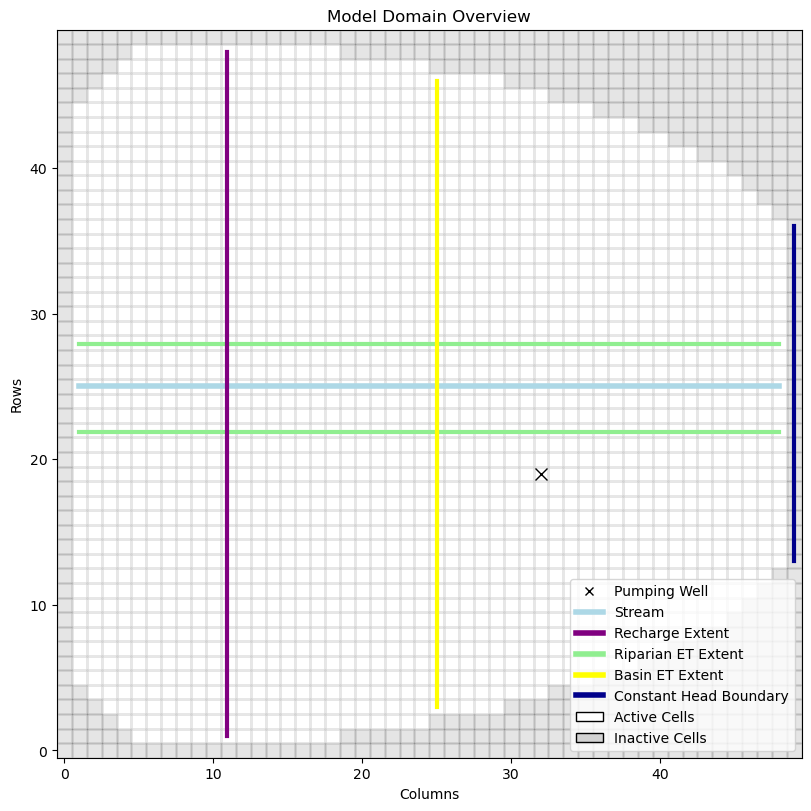

In [90]:
ibound = np.loadtxt('../base/ibound_lyr1.txt')            
all_well_loc = np.asarray(np.where(ibound == 1)).T

kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)

ztop = np.genfromtxt('../base/base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)


wellmesh_ztop = np.ndarray((50,50))
wellmesh_ztop[:,:] = 0

for k in range(len(all_well_loc)):
    wellmesh_ztop[int(all_well_loc[k, 1]), int(all_well_loc[k, 0])] = ztop[int(all_well_loc[k, 0]),int(all_well_loc[k, 1])]
wellmesh_ztop = np.ma.masked_array(wellmesh_ztop, wellmesh_ztop < 0.01)
river = np.ndarray((48,))
river[:] = 25

cmap_bd = cm.get_cmap("gray")#,lut=20)
cmap_bd.set_under("w")
cmap_bd.set_over("k")

cmap_ch = cm.get_cmap("Paired")#,lut=20)
cmap_ch.set_under("w")
#cmap_ch.set_over("k")

wellmesh_bd = np.ndarray((50,50))
wellmesh_bd[:,:] = -1e30
wm_ch = wellmesh_bd.copy()

CHBound_loc = np.where(all_well_loc[:,1] == 48) 
rch_bound = np.where(all_well_loc[:,1] < 10) 
et_bound = np.where(all_well_loc[:,1] >= 10)
#print(CHBound_loc)

for k in range(len(all_well_loc)):
    wellmesh_bd[int(all_well_loc[k, 1]), int(all_well_loc[k, 0])] = 2

for j in rch_bound[0]:
    wm_ch[int(all_well_loc[j, 1]), int(all_well_loc[j, 0])] = 3
for j in et_bound[0]:
    wm_ch[int(all_well_loc[j, 1]), int(all_well_loc[j, 0])] = 4     
for j in CHBound_loc[0]:
    wm_ch[int(all_well_loc[j, 1]), int(all_well_loc[j, 0])] = 2
wm_ch = np.ma.masked_array(wm_ch, wm_ch < 0.01)

    
fig, axs = plt.subplots(figsize=(8,8))
#plt.figure(figsize=(8,10))
alpha = 0.6
axs.pcolormesh(KK,GG,wellmesh_bd, cmap = cmap_bd, shading='nearest', alpha = 0.1, ec='grey')
#axs.pcolormesh(KK,GG,wellmesh_ztop, cmap = cm.terrain, shading='nearest', alpha = 0.5, ec='None')

#axs.pcolormesh(KK,GG,wm_ch, cmap = cmap_ch, shading='nearest', alpha = 0.5)
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='x', color='k',linestyle='None',label='Pumping Well'),
                   Line2D([0], [0], color='lightblue', lw=4, label='Stream'),
                   Line2D([0], [0], color='purple', lw=4, label='Recharge Extent'),
                   Line2D([0], [0], color='lightgreen', lw=4, label='Riparian ET Extent'),
                   Line2D([0], [0], color='yellow', lw=4, label='Basin ET Extent'),
                   Line2D([0], [0], color='darkblue', lw=4, label='Constant Head Boundary'),
                   Patch(facecolor='white', edgecolor='k',label='Active Cells'),
                   Patch(facecolor='lightgrey', edgecolor='k',label='Inactive Cells')]

axs.plot(range(1,49),river, lw=4,color="lightblue", label='River')
axs.plot(32, 19, marker="x", markersize=8, color="Black", linestyle = "None", label="Pumping Well")
axs.plot(range(1,49),np.repeat(27.9,48), lw=3,color="lightgreen", label="Riparian ET")
axs.plot(range(1,49),np.repeat(21.9,48),lw=3, color="lightgreen", label="Riparian ET")
axs.plot(np.repeat(10.9,48),range(1,49),lw=3, color="purple", label="Recharge Extent")
axs.plot(np.repeat(25,44),range(3,47),lw=3,color="yellow", label="ET Extent")
axs.plot(np.repeat(49,24),range(13,37),lw=3,color="darkblue", label="CH")
axs.set_xlabel('Columns')
axs.set_ylabel('Rows')
axs.set_title('Model Domain Overview')
axs.legend(handles = legend_elements,loc="lower right")
#plt.colorbar()
plt.savefig(r'C:\Users\davem\Documents\Thesis\DomainOverviewLayout.png')

AttributeError: Line2D.set() got an unexpected keyword argument 'z'

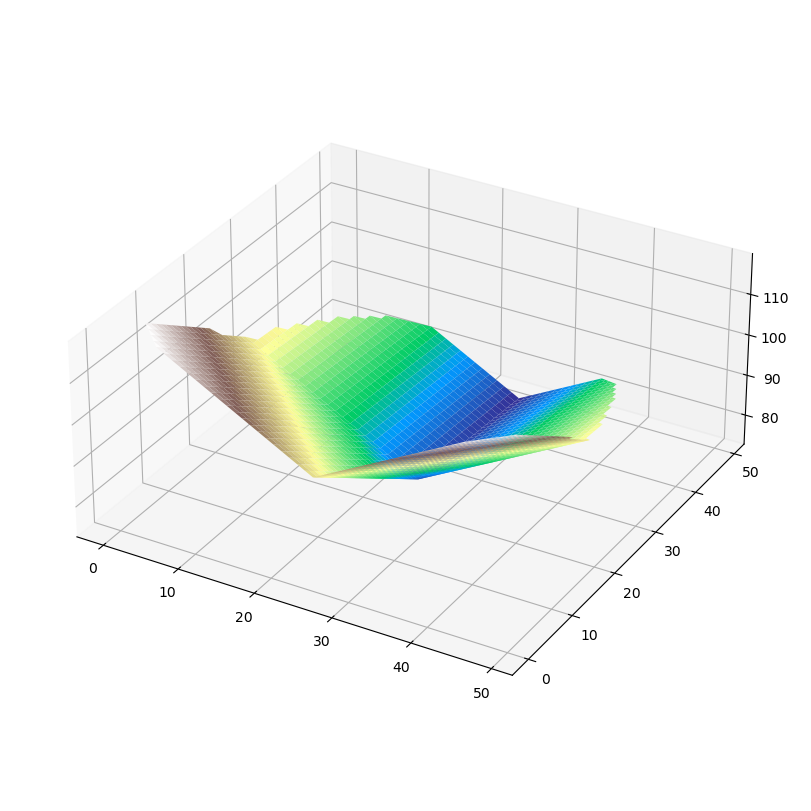

In [93]:
axes = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
axes.set_box_aspect([1,1,0.45], zoom=0.9)
axes.plot_surface(GG, KK, wellmesh_ztop, cmap = cm.terrain, edgecolor='None')
axes.set_title('Model Domain - Top Surface Elevations')
axes.set_ylabel('Columns (km)')
axes.set_xlabel('Rows (km)')
axes.set_zlabel('Elevation (m)')
labels = np.arange(0,6,1)
ticks = np.arange(0,60,10)
axes.set_xticks(ticks,np.flip(labels))
axes.set_yticks(ticks,labels)
axes.zaxis.labelpad=-0.5

axes.view_init(45,25,0)


plt.savefig(r'C:\Users\davem\Documents\Thesis\Topsurface.png')

In [ ]:
# df.plot(kind='scatter',x ='K',y='Rech',grid = True)
# sampledf = df[(df['K'] < 3) & (df['K'] > 1) & (df['Rech'] < .004) & (df['Rech'] > .003)]

# sampledf.plot(kind='scatter',x ='K',y='Rech',grid = True, figsize=(4,4))
# plt.title('Example of LHS for 2 Parameters')
# plt.show()

C:\Users\davem\AppData\Local\Temp\ipykernel_8976\1449876810.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("jet_r",lut=30)


[Text(0.0, 0, '-1'),
 Text(0.25, 0, '-0.5'),
 Text(0.5, 0, '0'),
 Text(0.75, 0, '0.5'),
 Text(1.0, 0, '1')]

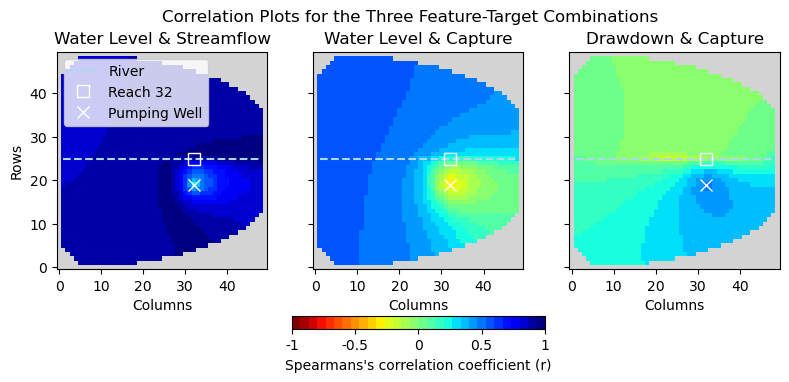

In [51]:
#plt.figure(figsize=(8,6))

kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)

wellmesh = np.ndarray((50,50))
wellmesh[:][:] = -1e30

def headPlot(wellmesh,rn,cmap2,colorbarlabel,title,vmax=None,vmin=-1):
    
    reach_label = "Reach " + str(rn)

    ax = plt.pcolormesh(KK,GG,wellmesh,cmap = cmap2, vmin = vmin,vmax=vmax,shading='nearest')
   
    #plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="w", mfc='none', linestyle = "None", label="Plot Location")
    #plt.plot(range(1,49),river, color="lightblue",label='River')
  #  plt.plot(rn,25, marker="s", markersize=8, color="w", mfc='none', linestyle = "None", label=reach_label)
    #plt.plot(32,19, marker="x", markersize=8, color="w", mfc='none', linestyle = "None", label="Pumping Well")
    plt.legend(facecolor='lightgray', loc='upper left')
    plt.xlabel('Columns')
    plt.ylabel('Rows')

    plt.title(title)

  
    return ax

cmap2 = cm.get_cmap("jet_r",lut=30)
cmap2.set_under("lightgray")
river = np.ndarray((48,))
river[:] = 25
rn = 25
title = 'Correlations of Location Drawdown Levels with Capture at Prediction Reach'
colorbarlabel = 'Spearmans\'s correlation coefficient (r)'

DrawCapCorr = np.loadtxt("../CorrDrawCap.csv")
HeadCapCorr = np.loadtxt("../CorrHeadCap.csv")
HeadQCorr = np.loadtxt("../CorrHeadQ.csv")

fig, axs = plt.subplots(1, 3, sharex=False, sharey=True,figsize=(8, 4))
fig.suptitle('Correlation Plots for the Three Feature-Target Combinations')
#fig.supylabel('Rows')

fig.tight_layout()
#print(axs[0])
axs[0].pcolormesh(KK,GG,HeadQCorr,cmap = cmap2, vmin = -1,vmax=1,shading='nearest')
axs[0].set_title('Water Level & Streamflow')
axs[0].set_ylabel('Rows')
axs[1].pcolormesh(KK,GG,HeadCapCorr,cmap = cmap2, vmin = -1,vmax=1,shading='nearest')
axs[1].set_title('Water Level & Capture')
axs[2].pcolormesh(KK,GG,DrawCapCorr,cmap = cmap2, vmin = -1,vmax=1,shading='nearest')
axs[2].set_title('Drawdown & Capture')

reach_label = 'Reach 32'
for i in axs:
  #  i.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="w", mfc='none', linestyle = "None", label="Plot Location")
    i.plot(range(1,49),river,linestyle='dashed', color="lightblue",label='River')
    i.plot(32,25, marker="s", markersize=8, color="w", mfc='none', linestyle = "None", label=reach_label)
    i.plot(32,19, marker="x", markersize=8, color="w", mfc='none', linestyle = "None", label="Pumping Well")
    i.set_xlabel('Columns')
axs[0].legend(loc='upper left')    
cbar = fig.colorbar(mp.cm.ScalarMappable(cmap=cmap2), ticks = [0,0.25,0.5,0.75,1], ax = axs[:], orientation='horizontal',shrink = 0.35, label=colorbarlabel)
cbar.ax.set_xticklabels([-1,-.5,0,0.5,1])